# Entrenamiento usando SVM y HOG SKLEARN

# Carga de los datasets de Train y Tests

In [2]:
import os
import cv2
import numpy as np

#Definición de los directorios del dataset
#base_dir = r'C:\Users\jockr\Desarrollo\petsDataset'
#base_dir = "/home/phoenix/git/vision_artificial_linux/src/lab7/PetsDataSet"
base_dir = str(os.getcwd()) + "/../PetsDataSet"
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Directorio con las imagenes de training 
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
train_parrots_dir = os.path.join(train_dir, 'parrots')

# Directorio con las imagenes de test
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')
test_parrots_dir = os.path.join(test_dir, 'parrots')

# Lista de Nombres de Archivos de Train
train_cat_fnames = os.listdir(train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )
train_parrot_fnames = os.listdir( train_parrots_dir )

# Lista de Nombres de Archivos de Test
test_cat_fnames = os.listdir( test_cats_dir )
test_dog_fnames = os.listdir( test_dogs_dir )
test_parrot_fnames = os.listdir( test_parrots_dir )

# Lista de Rutas de archivos de train
train_cat_fnames = list(map(lambda x: os.path.join(train_cats_dir, x) , train_cat_fnames)) 
train_dog_fnames = list(map(lambda x: os.path.join(train_dogs_dir, x) , train_dog_fnames)) 
train_parrot_fnames = list(map(lambda x: os.path.join(train_parrots_dir, x) , train_parrot_fnames)) 


# Lista de Rutas de archivos de test
test_cat_fnames = list(map(lambda x: os.path.join(test_cats_dir, x) , test_cat_fnames))
test_dog_fnames = list(map(lambda x: os.path.join(test_dogs_dir, x) , test_dog_fnames))
test_parrot_fnames = list(map(lambda x: os.path.join(test_parrots_dir, x) , test_parrot_fnames))


# Lista con todas las paths de archivos de train
train_fnames = train_cat_fnames + train_dog_fnames + train_parrot_fnames

# Lista con todas las paths de archivos de test
test_fnames = test_cat_fnames + test_dog_fnames + test_parrot_fnames


# Prepara las etiquetas de cada instancia de train
train_labels =[ 0 for _ in train_cat_fnames ]
train_labels.extend([ 1 for _ in train_dog_fnames ])
train_labels.extend([ 2 for _ in train_parrot_fnames ])


# Prepara las etiquetas de cada instancia de test
test_labels =[ 0 for _ in test_cat_fnames ]
test_labels.extend([ 1 for _ in test_dog_fnames ])
test_labels.extend([ 2 for _ in test_parrot_fnames ])



# Funciones para generar la matriz de confusión del modelo

In [3]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def generarMC(model, X, y, categorias, normal=None ):
    fig=ConfusionMatrixDisplay.from_estimator(model, X, y, display_labels=categorias, cmap="Greens", normalize=normal)  
    fig.figure_.suptitle("Confusion Matrix")
    plt.show()
    
def generarMCPredictions(y_real, y_pred, categorias ):
    fig=ConfusionMatrixDisplay.from_estimator(y_real, y_pred, display_labels=categorias, cmap="Greens")  
    fig.figure_.suptitle("Confusion Matrix")
    plt.show()

# Extracción de Descriptores HOG

In [4]:
def get_hog(list_fnames):
    # Definir Resolucion de las imagenes a usar
    img_size =(380,380)

    # Definir los parámetros del descriptor HOG
    win_size = img_size     # Tamaño de la ventana de detección
    block_size = (40, 40)   # Tamaño del bloque
    block_stride = (20, 20) # Desplazamiento del bloque
    cell_size = (20, 20)    # Tamaño de la celda
    nbins = 9               # Número de bins del histograma

    # Crear un descriptor HOG con parámetros personalizados
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)

    hog_descriptor_set = []
    for imgs in list_fnames:
        # Cargar la imagen 
        orgimage = cv2.imread(  imgs  )
        image = cv2.resize(orgimage, img_size)

        # Convertir la imagen a escala de grises 
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
        # Calcular los descriptores HOG de la imagen en escala de grises
        hog_descriptors = hog.compute(gray_image)
        hog_descriptor_set.append(hog_descriptors)
    
    # Remover los ejes/dimensiones de longitud 1 de la lista
    hog_descriptor_set = np.squeeze(hog_descriptor_set) 
    return hog_descriptor_set
    

# Obtención de los Descriptores HOG para las secuencias de Train y Test

In [5]:
train_hog = get_hog(train_fnames)
test_hog = get_hog(test_fnames)

# Usando Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier

#Definición del Modelo 
clfRF = RandomForestClassifier(n_jobs=6, 
                               random_state=0, 
                               n_estimators=1000,
                               )
#fit/train -> Se hace el entrenamiendo del modelo
clfRF.fit(train_hog, np.array(train_labels))


RandomForestClassifier(n_estimators=1000, n_jobs=6, random_state=0)

In [7]:
# Precisión lograda por el clasificador
print(f'{clfRF.score(test_hog, np.array(test_labels)):.2%}')


60.19%


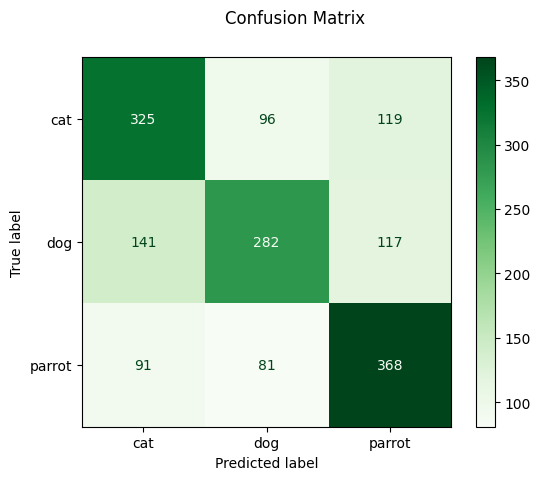

In [8]:
# Matriz de confusión no normalizada
generarMC(clfRF, test_hog, test_labels, ['cat', 'dog','parrot'] )

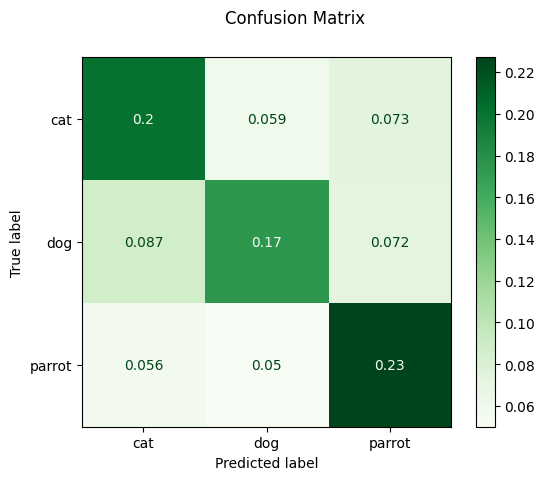

In [9]:
# Matriz de confusión normalizada
generarMC(clfRF, test_hog, test_labels, ['cat', 'dog','parrot'], 'all')

In [ ]:
def clasificar(path):
    global clfrf
    hogdesc = get_hog([path])
    labels = ['cat', 'dog','parrot']
    res = clfrf.predict(hogdesc.reshape(1, -1))
    resprob = clfrf.predict_proba(hogdesc.reshape(1, -1))
    labelresultado = f'en la imagen aparece un {labels[res[0]]}, con una probalidad de { resprob[0,res[0]]:.2%}' 
    return labelresultado

In [ ]:
import gradio as gr

gr.Interface(
    fn = clasificar,    # funcion 
    inputs = gr.Image(type="filepath"), # tipo de entrada
    outputs = "textbox"  
).launch()

/home/phoenix/git/vision_artificial_linux/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
which: no node in (/home/phoenix/git/vision_artificial_linux/bin:/mnt/files/git/vision_artificial_linux/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/home/phoenix/.local/share/flatpak/exports/bin:/usr/lib/jvm/default/bin:/opt/rocm-6.2.1/bin:/opt/rocm-6.2.1/hip/bin:/usr/bin/site_perl:/usr/bin/vendor_perl:/usr/bin/core_perl:/usr/lib/rustup/bin)


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


[ WARN:8@4910.036] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
Traceback (most recent call last):
  File "/home/phoenix/git/vision_artificial_linux/lib/python3.12/site-packages/gradio/queueing.py", line 624, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/phoenix/git/vision_artificial_linux/lib/python3.12/site-packages/gradio/route_utils.py", line 323, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/phoenix/git/vision_artificial_linux/lib/python3.12/site-packages/gradio/blocks.py", line 2018, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/phoenix/git/vision_artificial_linux/lib/python3.12/site-packages/gradio/blocks.py", line 1567, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ig